In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.io as sio
import scipy
from sklearn import neighbors
#%matplotlib inline

In [23]:
def PCA(data,dimensions):
    '''
    data is the original data set，rows are samples of data,columns are the features
    '''
    [N, D] = data.shape
    # making data zero-means
    average = np.mean(data,0)
    data = np.mat(data-average)
    
    #covariance
    covariance = np.dot(data.T, data)
    
    #eigenvalues
    eig_var, eig_vec = np.linalg.eig(covariance)
    
    
    #from the numpy doc, the eig_var may not be ordered.
    sort_eig = np.argsort(-eig_var)
    #return the index that make a sorted array

    #so we got the sorted eig_var
    sort_eig = sort_eig[:dimensions]
    principal_vec = eig_vec[:,sort_eig]
    low_data = np.dot(data, principal_vec).astype(float)
    return principal_vec, low_data


In [24]:
def FLD(data, label, d):
    # Number of samples N; Dimensions D; Clases c
    [N, D] = data.shape
    c = len(np.unique(label))
    
    
    # W_opt.T = W_fld.T * W_pca.T
    # W_pca
    # Get the principal components of PCA with N-c largest eigenvalues
    W_pca, data_pca= PCA(data, N-c)
    
    # W_fld
    # S_B
    
    #total mean
    mean_total = data_pca.mean(axis=0)
    
    S_W = np.zeros((N-c, N-c)) 
    S_B = np.zeros((N-c, N-c))
    
    for i in range(1,c+1):
        # mean of class
       
        data_i = data_pca[np.where(label == i)]
        mean_i = data_i.mean(axis=0)
        S_B = S_B + N * np.dot((mean_i - mean_total).T, mean_i - mean_total)
        S_W = S_W + np.dot((data_i - mean_i).T, (data_i - mean_i))
        
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))
    sort_eig = np.argsort(-eigenvalues)
    W_fld = eigenvectors[:, sort_eig[:d]]
   
    W_opt = np.dot(W_pca, W_fld)
    return np.dot(data, W_opt), W_opt

In [25]:
data=sio.loadmat("Yale_32x32.mat")
face = data['fea']
label = data['gnd']
label = np.squeeze(label)
print(face.shape)
print(label.shape)
data_fld, W = FLD(face, label, 14)

(165, 1024)
(165,)


/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


(1024, 14)
(165, 14)


/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


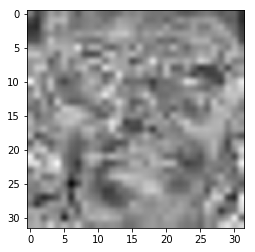

In [26]:
print(W.shape)
print(data_fld.shape)
fisherface=W.T[0]
fisherface=fisherface.reshape(32, 32).astype(float)
pylab.imshow(fisherface.T, cmap='gray', interpolation='hamming')
pylab.show()

In [33]:
def knn_verification(train_data, train_label, test_data, test_label):
    knn = neighbors.KNeighborsClassifier(n_neighbors = 5)  
    knn.fit(train_data, train_label)
    pre = knn.predict(test_data)
    return pre[0]==test_label

In [34]:
def Leaving_one_out(d):
    ## 32 * 32 Yale_faces 
    s=0.0
    
    for i in range(165):
        index = [i for i in range(165)]
        index.remove(i) 
        trainface = face[index]
        trainlabel = label[index]
        testface = face[i].reshape((1, 32*32))
        testlabel = label[i].reshape((1, 1))
        
        traindata, mapping= FLD(trainface, trainlabel, d)
        
        testdata = np.dot(testface, mapping)
       
        if(knn_verification(traindata, trainlabel, testdata, testlabel)==False):
            s+=1
    return s/165

s = Leaving_one_out(15)
print("score" ,s)

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


score 0.18181818181818182
